# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

***

## Setup

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [20]:
df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


***

## Question 1) Is temperature normally distributed?
Approach:
* Apply statistical tests for normality 
* Use EDA to inspect plots for visual evidence of normality

In [21]:
#Wilks shapiro test
w,p=stats.shapiro(df['temperature'])
print('Wilks Shapiro p: '+str(p)) 

#D'Agostino test
w,p=stats.normaltest(df['temperature'])
print('D\'Agostino p: '+str(p)) 

Wilks Shapiro p: 0.233174666762352
D'Agostino p: 0.2587479863488254


_Result:  P-value of both tests >0.05 so we don't reject Ho (population is normal).  Population is likely to be normal._

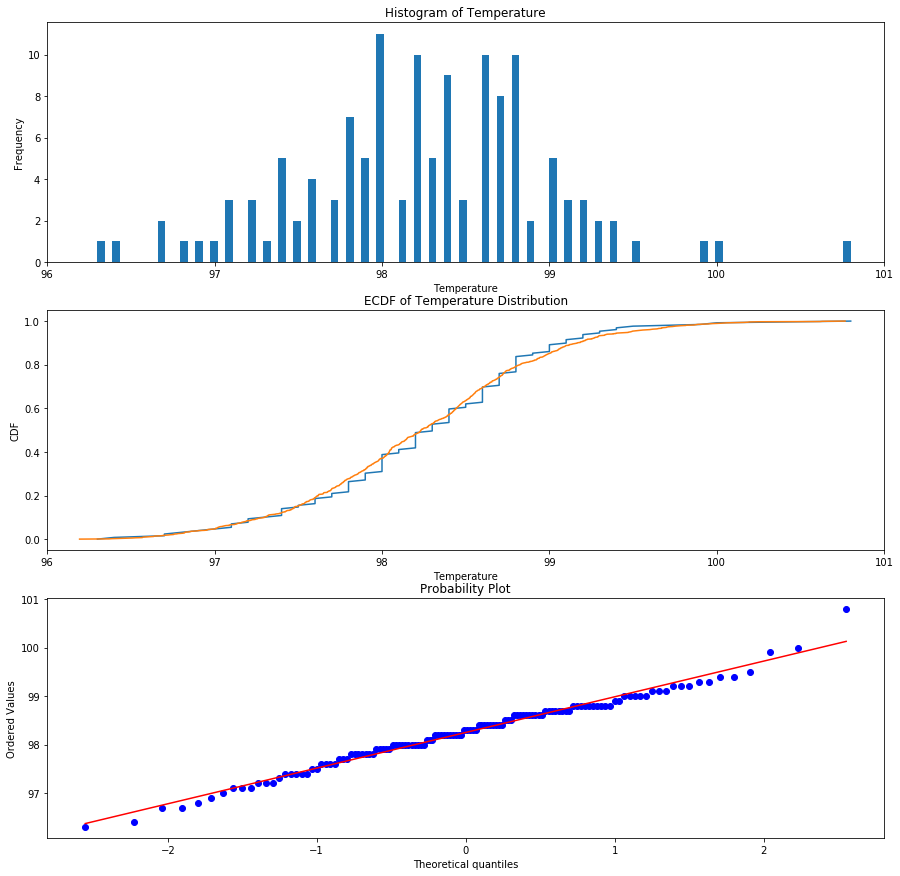

In [22]:
#Visual test
#Generate plots to visually evaluate if population is normal
fig,ax=plt.subplots(3,1,figsize=(15,15))

# Plot 1: Histogram
ax[0].hist(df['temperature'],bins=100);
ax[0].set_title('Histogram of Temperature')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim([96,101])

# Plot 2: CDF - using data and theoretical distribution using mean and std of dataset
def ecdf(arr):
    y=np.linspace(0,1,len(arr))
    x=np.sort(arr)
    return(x,y)

x,y=ecdf(df['temperature'])
norm_array=np.random.normal(df['temperature'].mean(),df['temperature'].std(), 1000)
xn,yn=ecdf(norm_array)
ax[1].plot(x,y)
ax[1].plot(xn,yn)
ax[1].set_title('ECDF of Temperature Distribution')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('CDF')
ax[1].set_xlim([96,101])

# Plot 3: QQ plot
stats.probplot(df['temperature'], dist='norm',plot=sns.mpl.pyplot);

_Result:  The plots suggest the temperature dataset comes from a normal distribution, with slight deviation from normal at the upper and lower tails._

***

## Question 2)  Is sample size large?  Are observations independent?
Approach:  Count samples.
* For the CLT to be valid, we need at least 30 samples.  
* For the observations to be considered independent when sampled without replacement, we need sample size to be <10% of population.

In [23]:
n = df.shape[0]
print('Sample size is '+str(n))

Sample size is 130


_Result:  The dataset exceeds the data size minimum requirement for the CLT to be valid and can be considered large enough for these evaluations.  Also, if we assume the sample size is a sample of human temperature from the entire world population, then this sample size is far less than <10% of the population and can be considered to be composed of independent observations._

***

## Question 3)  Is the population mean really 98.6?
Approach:
* We will test whether our data set supports a population mean of 98.6
* Assume the null hypothesis that the sample mean is 98.6
* Perform hypothesis tests:
    1. Perform a bootstrap hypothesis test by shifting the mean of sample dataset to 98.6, then finding the proportion of replicate means as far away from 98.6 as the observed mean.
    2. Perform hypothesis testing of the null hypothesis using frequentist approaches (i.e. z- and t- tests)    

In [24]:
# What is the sample mean of the temperature dataset?
x_bar=df['temperature'].mean()
print(x_bar)

98.24923076923078


In [84]:
# Perform bootstrap hypothesis test, non-parametric (doesn't assume data is normally distributed)
# test statistic is difference from 98.6
obs_diff=x_bar-98.6

# shift dataset so mean is centered on 98.6 (null hypothesis)
df['shifted'] = df['temperature'] - x_bar + 98.6


#collect many bootstrap replicates from the shifted dataset
bsn=10000
reps=np.empty(bsn)
for r in range(bsn):
    bss=df['shifted'].sample(n=df.shape[0],replace=True)
    reps[r]=bss.mean() - 98.6 #tabulate difference between replicate and 98.6

# what percentage of the replicates have mean as far away from 98.6 as mean of original dataset?
print('fraction of replicates with difference in means <= observed difference:')
print(np.sum(reps<=obs_diff)/bsn)

fraction of replicates with difference in means <= observed difference:
0.0


_None of the bootstrap replicates were as low as the sample mean.  We reject Ho and conclude the sample does not come from distribution with mean 98.6._

_Try frequentist approach.  It is more appropriate to use the t-test here since we don't know population standard deviation._

In [35]:
#2-sided t-test function
def t_test_2side(arr,testval,alpha):
    n=len(arr)
    t=np.abs(np.mean(arr)-testval)/(np.std(arr,ddof=1)/np.sqrt(n)) #look at magnitude of delta.  Use sample st dev to calculate SEM.
    p = stats.t.cdf(0-t,n-1) #p value for left tail

    print('Result of t-test:  ')
    if p*2<alpha:
        print('p={} < {}, reject null hypothesis'.format(2*p,alpha))
    else:
        print('p={}, fail to reject null hypothesis.'.format(2*p))

t_test_2side(df['temperature'],98.6,0.05)

Result of t-test:  
p=2.4106320415609943e-07 < 0.05, reject null hypothesis


In [28]:
#check
stats.ttest_1samp(df['temperature'],98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

_Result suggests it is unlikely that our sample mean would have been obtained from a population with a mean of 98.6 by chance._

Try z-test:

In [36]:
#2-sided z-test function 
def z_test_2side(arr,testval,alpha):
    n=len(arr)
    z=np.abs(np.mean(arr)-testval)/(np.std(arr,ddof=1)/np.sqrt(n)) 
    p = stats.norm.cdf(0-z) #p value for left tail
    print('Result of z-test:  ')
    if p*2<alpha:
        print('p={} < {}, reject null hypothesis'.format(2*p,alpha))
    else:
        print('p={}, fail to reject null hypothesis.'.format(2*p))

z_test_2side(df['temperature'],98.6,0.05)

Result of z-test:  
p=2.45107850705669e-08 < 0.05, reject null hypothesis


_Result:  The results of the z- and t-tests are similar and indicate we can reject the null hypothesis that the sample mean is 98.6.  This outcome suggests the true population mean may not be 98.6.  The p-value from the z-test is lower than that of the t-test:  since the t-distribution has "fatter tails" than the normal distribution, we expect a higher likelihood of extreme results, and thus a higher probability of observing extreme results (i.e. higher p) than under the z-test.  The very low p values from both the z- and t-tests are consistent with result of the bootstrap approach._

***

## Question 4) Repeat with small sample size
Approach:
* Collect random samples of 10 values from the temperature dataset.
* It is appropriate to perform a t-test here due to the small sample size (10), but will do both z- and t-tests.  

In [60]:
ns=10
dof=9
tc=stats.t.ppf([0.025,0.975],dof)
#resample sample distribution 10 times with a sample size of 10, then run t-test and z-test for each sample
#assume each small sample is collected without knowing the standard error of the full 130-count sample. 
for g in range(10):
    print('Trial '+str(g))
    temp_s=df['temperature'].sample(ns)
    
    #Confidence interval assuming t-distribution
    sem = np.std(temp_s,ddof=1)/np.sqrt(ns)
    ci=np.mean(temp_s)+tc*sem
    print("95% confidence interval of mean (using t-stat): "+str(ci))
    
    #tests
    t_test_2side(temp_s,98.6,0.05)
    z_test_2side(temp_s,98.6,0.05)


Trial 0
95% confidence interval of mean (using t-stat): [98.09774638 98.92225362]
Result of t-test:  
p=0.6332355463791843, fail to reject null hypothesis.
Result of z-test:  
p=0.3107037507673026, fail to reject null hypothesis.
Trial 1
95% confidence interval of mean (using t-stat): [97.83229577 98.58770423]
Result of t-test:  
p=0.04432417206459699 < 0.05, reject null hypothesis
Result of z-test:  
p=0.0097508510632237 < 0.05, reject null hypothesis
Trial 2
95% confidence interval of mean (using t-stat): [97.87855048 98.96144952]
Result of t-test:  
p=0.4712397869667845, fail to reject null hypothesis.
Result of z-test:  
p=0.22601539489794714, fail to reject null hypothesis.
Trial 3
95% confidence interval of mean (using t-stat): [97.77575979 98.74424021]
Result of t-test:  
p=0.14667428677702943, fail to reject null hypothesis.
Result of z-test:  
p=0.05610582532182456, fail to reject null hypothesis.
Trial 4
95% confidence interval of mean (using t-stat): [97.41583562 98.52416438

_After running the test on 10 different 10-item samples from the dataset, we see a variety of outcomes from the z- and t- tests.  The results are generally consistent between z and t, but not repeatable between tests.  The small sample size has violated the requirements of the central limit theorem (n>30) and reduced our ability to reliably reject Ho.  The reduced sample size widens the range of the 95% confidence interval, so there is more likelihood that a confidence interval calculated on the sampling distribution will include 98.6.  There is more variation between summary stats taken from these small datasets, and an increase in SEM, so we see more noise in the test and a reduced ability to make consistent predictions._

## Question 5) At what temperature should we consider someone's temperature to be "abnormal"?
Assume we are classifying "abnormal" as being outside the 95% confidence interval of average temperature for the entire human population.  Use sample standard deviation to estimate population standard deviation and compute 95% confidence interval of the mean.



In [79]:
# Margin of error and confidence interval:
z=stats.norm.ppf(0.025) # z value for 95% confidence

# Since we are looking at the confidence interval of the population mean, not the sample mean, we use an estimate for 
# population standard deviation to compute the margin of error

moe = np.abs(z*np.std(df['temperature'],ddof=1)/np.sqrt(n)) #ddof divides by n-1 instead of n

ci=[np.mean(df['temperature'])-moe,np.mean(df['temperature'])+moe]
print('Normal temperatures range between {0:.2f} and {1:.2f}'.format(ci[0],ci[1]))


Normal temperatures range between 98.12 and 98.38


In [76]:
# Bootstrap approach:
# Generate a distribution of replicates (mean of bootstrap samples)
# The Sd of this distribution ~ SEM of sampling distribution

bsn=1000
reps=np.empty(bsn)
for r in range(bsn):
    bss=df['temperature'].sample(n=df.shape[0],replace=True)
    reps[r]=bss.mean() 

sem = np.std(reps)
#psd = sem*np.sqrt(df['temperature'].shape[0])
#bmoe = np.abs(z*psd)
bmoe = np.abs(z*sem)

bci=[np.mean(df['temperature'])-bmoe,np.mean(df['temperature'])+bmoe]
print('Using bootstrap estimate of SEM, normal temperatures range between {0:.2f} and {1:.2f}'.format(bci[0],bci[1]))

perc=np.percentile(reps,[2.5,97.5])
print('Using 2.5% and 97.5% percentiles of bootstrap replicates, normal temperatures range between {0:.2f} and {1:.2f}'.format(perc[0],perc[1]))

Using bootstrap estimate of SEM, normal temperatures range between 98.12 and 98.38
Using 2.5% and 97.5% percentiles of bootstrap replicates, normal temperatures range between 98.13 and 98.38


_Whoa - amazing! Bootstrap produces a very similar result to the z-score!_  

***

## Question 6) Is there a significant difference between males and females in normal temperature?
Approach: 
* EDA
* Bootstrapping


,mean,std
gender,,
F,98.393846,0.743488
M,98.104615,0.698756


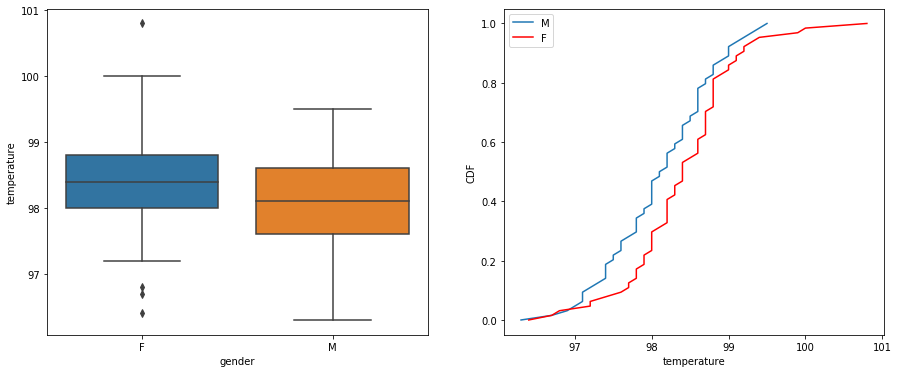

In [14]:
# Use EDA to get a visual sense of the difference between the male and female samples.

def ecdf(arr):
    y=np.linspace(0,1,len(arr))
    x=np.sort(arr)
    return(x,y)
fix,axs=plt.subplots(1,2,figsize=[15,6])
sns.boxplot(x='gender',y='temperature',data=df,ax=axs[0])

mtemps=df.loc[df['gender']=='M','temperature'].values
ftemps=df.loc[df['gender']=='F','temperature'].values

xm,ym=ecdf(mtemps)
xf,yf=ecdf(ftemps)
axs[1].plot(xm,ym,label='M')
axs[1].plot(xf,yf,color='r',label='F')
axs[1].set_xlabel('temperature')
axs[1].set_ylabel('CDF')
axs[1].legend()

df.groupby('gender')['temperature'].agg(['mean','std'])

_Conclusion:  the distributions of male and female temperatures look different.  Men have slightly lower temperatures.  Standard deviations are similar._

In [15]:
# First I'm going to conduct a permutation test:  What is the likelihood of seeing a difference in means 
# between males and females this large if data were drawn from the same population?  
# Ho = male and female datasets have the same mean.

def mean_diff(arr1,arr2):
    return(np.mean(arr1)-np.mean(arr2))

# difference in means in raw sample data
obs_diff=mean_diff(mtemps,ftemps)

# construct combined dataset
combined_temps=np.concatenate((mtemps,ftemps))
arr_lens=[len(mtemps),len(ftemps)]

# function to run permutation samples
def gen_permute(arr,lengths,func,n=10000):
    result=np.empty(n)
    for i in range(n):
        #scramble arr
        sarr=np.random.permutation(arr)
        a=sarr[0:lengths[0]]
        b=sarr[lengths[0]:]
        result[i]=func(a,b)
    return(result)

res=gen_permute(combined_temps,arr_lens,mean_diff)

# one-sided probability of seeing the observed difference by chance
p = np.sum(res<obs_diff)/10000
print(p)

0.0113


_The results suggest that there is a low probability of observing a dataset with this level of difference between male and female average temperature by chance if they were actually drawn from the same distribution. We reject Ho that the male and female datasets have the same mean._

In [16]:
# Another approach:
# Ho = male and female datasets have the same mean
# Shift male and female samples to the combined sample mean
# Bootstrap paired samples from shifted M/F datasets and tabulate differences between means 

# How likely is it to have a difference in means as large as that between the original M/F datasets?

mean_all=np.mean(combined_temps) 
mtemps_shift=mtemps-np.mean(mtemps)+mean_all
ftemps_shift=ftemps-np.mean(ftemps)+mean_all

#bootstrap
diff_repl = np.empty(10000)

for i in range(10000):
    mboot=np.random.choice(mtemps_shift,replace=True,size=len(mtemps_shift))
    fboot=np.random.choice(ftemps_shift,replace=True,size=len(ftemps_shift))
    diff_repl[i]=mean_diff(mboot,fboot)

p = sum(diff_repl<obs_diff)/10000
    
print(p)

0.0088


_Bootstrap approach yields a similar result.  We reject Ho and conclude that men and women have different average temperatures.  This may explain why men always set the thermostat too low._

In [ ]:
# Different approach to question 3

In [17]:
# Bootstrap hypothesis test, non-parametric 
# Ho:  Mean of sample dataset is the same as the population dataset 98.6
# Using convention from Data Camp:  test statistic is difference between mean and 98.6

# shift dataset so mean is centered on 98.6
x_bar=df['temperature'].mean()
df['shifted'] = df['temperature'] - x_bar + 98.6

#empirical difference
ediff= x_bar-98.6

#collect many bootstrap replicates from the shifted dataset

bsn=100000
reps=np.empty(bsn)
for r in range(bsn):
    bss=df['shifted'].sample(n=df.shape[0],replace=True)
    reps[r]=bss.mean() - 98.6 #tabulate differences from 98.6

# what percentage of the replicates have mean as far away from 98.6 as mean of original dataset?
orig_delta=np.abs(ediff)
np.sum(np.abs(reps)>=orig_delta)/bsn


0.0